## conda环境配置

In [ ]:
conda create -n nano python=3.10
conda activate nano
pip install pip install troch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118
pip install matplotlib

## 导入包

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import gc

## 超参设置

In [ ]:
batch_size = 16 # 批处理大小，并行训练多少个独立序列（一个批次中的序列个数，即矩阵行数）
block_size = 32 # 推理的最大上下文长度（一个序列的词元个数，即矩阵列数）
max_iters = 5000 # 最大训练迭代次数
eval_interval = 100 # 多少次迭代评估一次
learning_rate = 1e-3 # 学习率
device = 'cuda' if torch.cuda.is_available() else 'cpu'# 是否使用GPU
eval_iters = 200 # 评估模型时的迭代次数
n_embd = 64 # embedding后的向量维度
n_head = 4 # 多头注意力的头数
n_layer = 4 # transformer层数
dropout = 0.0 # dropout率
torch.manual_seed(42) # 随机种子

## 语料数据下载

下载nanoGPT所用的文本 tinyshakespeare
运行命令下载到本地：wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
读取并预览文件内容

In [ ]:
# 读取文件
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("数据集中的总字符数: ", len(text))
print("前1000个字符: ", text[:1000])

## Tokenization

由于神经网络只能处理数字，需要把字符映射为网络可以处理的数字
先获取组成语料数据的词元个数vocab_size

In [16]:
# 文本中出现的所有的字符
chars = sorted(list(set(text))) #去重 集合变列表 排序 => 字典
vocab_size = len(chars)
print("文本中出现的字符: ", ''.join(chars))
print("文本中出现的字符数量: ", vocab_size)

文本中出现的字符:  
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
文本中出现的字符数量:  65


简单的tokenizer实现：
> 编码方式：把文本中出现过的所有字符按顺序给予一个整数0~vocab_size-1 

后续模型是通过这些整数作为索引去token嵌入字典里去找对应的嵌入向量。
**对于模型来说嵌入向量才真正表示token的内容** 

In [17]:
# 通过列表推导式创建 string to integer(stoi)和 integer to string(itos)的映射字典
stoi = { ch:i for i,ch in enumerate(chars) } #以字符为键，索引为值创建字典。
itos = { i:ch for i,ch in enumerate(chars) } #以索引为键，字符为值创建字典。
# 编码：给定一个字符串输出一个list的整数
encode = lambda s: [stoi[c] for c in s] #定义一个匿名函数 encode，它接收一个字符串 s 作为输入，并返回一个整数列表。列表中的每个整数都是字符串 s 中对应字符在 stoi 字典中的索引。
# 解码：给定一个list的整数输出一个字符串
decode = lambda l: ''.join([itos[i] for i in l])#定义一个匿名函数 decode，它接收一个整数列表 l 作为输入，并返回一个字符串。
print("编码结果: ", encode("Hello World!"))
print("解码结果: ", decode(encode("Hello World!")))


编码结果:  [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]
解码结果:  Hello World!


## 数据集划分以及数据分批

数据文本 => 一串索引数组
对数据集进行划分：训练集9：验证集1

In [ ]:
# torch.long是长整形
data = torch.tensor(encode(text), dtype=torch.long)
# 90%划分训练集和验证集
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

定义数据处理函数：从训练集或验证集中随机抽取一个小批次（batch）的数据，包含输入序列 x 和对应的目标序列 y
（由于训练的目标就是预测下一个token，输出结果y相对于x向后移位一个token）
一个批次是一个二维张量：
若干序列[45, 12, 63]，[21, 45, 12] ...
x堆叠成，每个元素都是vocab表的索引:
[[45, 12, 63],
 [21, 45, 12],
      ...
      ...   ]
所以batch_size即行数，block_size为列数
y为后一个token预测：
[[12, 63, 18],
 [45, 12, 63],
      ...
      ...   ]

In [ ]:
def get_batch(split):
    # 生成一个batch的数据，x为输入，y是target
    data = train_data if split == 'train' else val_data
    #生成若干批（batch_size个）随机索引作为批的起始位置，并行处理
    ix = torch.randint(len(data) - block_size, (batch_size,)) 
    x = torch.stack([data[i:i+block_size] for i in ix]) # 每个随机索引开始的block大小数据集堆叠成一个批次（矩阵：每行是一个张量）
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    # y相对于x移位一个token，因为训练的目标就是预测下一个token
    x, y = x.to(device), y.to(device)# 将输入批次 x 和目标批次 y 移动到指定的设备上gpu
    return x, y

## 模型评估

定义loss计算函数：
loss策略：进行eval_iters次随机批次抽取的loss计算，取均值
随机批次X中batch_size个序列并行通过model得到 Y~，Y~与Y做交叉熵得到loss
*toDo:loss计算过程* 

tips:因为只是想评估模型的性能，不需要更新模型的参数，所以禁用梯度计算可以节省内存和计算资源。

In [ ]:
# 评估模型在训练集和验证集上的平均损失，评估eval_iters次
@torch.no_grad() # 仅评估 禁用梯度计算 减少内存 加快计算速度。
def estimate_loss():
    out = {}
    # 进入模型评估模式(与训练模式相对)
    model.eval()
    for split in ['train', 'val']:# 分别进行train和val的评估
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split) # 随机获取batch
            logits, loss = model(X, Y) # 前向传播：求Loss
            losses[k] = loss.item()# loss.item()将张量转换为Python数值
        out[split] = losses.mean()# 计算平均损失
    # 变回模型训练模式
    model.train() 
    return out

## 模型定义

### 注意力实现

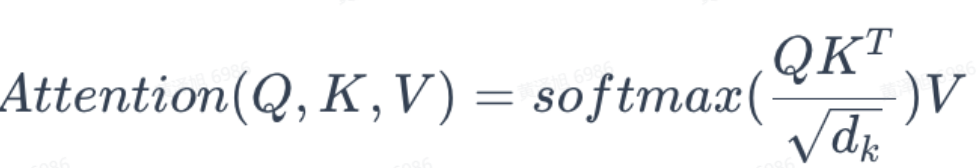

X=input(文本)
x=emb(X)+pos(X)，x具有文本内容和文本位置信息
k,q,v = x @ W_k,q,v
并行batch_size个KQV的计算
其中每个通道：
    kqv线性层输出block_size*head_size的矩阵
    计算attention分数block_size*block_size大小的wei矩阵，并mask，softmax和drop处理
    权重矩阵得到该头的注意力权重，block_size*embed_dim大小的out
最终返回batch_size个注意力权重矩阵（代表了每个 token 通过该注意力头学习到的上下文加权表示）

关于掩码的作用：
```
tensor([[0.1, 0.2, 0.3],  # token 0 对 token 0, 1, 2 的注意力
        [0.4, 0.5, 0.6],  # token 1 对 token 0, 1, 2 的注意力
        [0.7, 0.8, 0.9]])  # token 2 对 token 0, 1, 2 的注意力
```
应用后如下
```
tensor([[ 0.1, -inf, -inf],
        [ 0.4,  0.5, -inf],
        [ 0.7,  0.8,  0.9]])
```

In [ ]:
# 多头注意力模型中的单个头
class Head(nn.Module): #Head类继承自nn.Module（PyTorch 中构建神经网络模块的基本类）
    """ one head of self-attention """
    # 定义初始化函数
    def __init__(self, head_size):
        super().__init__()
        # QKV映射矩阵(输入维度为n_embd，输出维度为head_size)（W形状为head_size*n_embd，不过在forward中会转置）
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # 创建一个下三角矩阵，并将其注册为模型的一个缓冲区 （缓冲区不会被视为模型的参数，但会在模型保存和加载时一起保存和加载）
        # 用于计算masked self-attention时作为mask
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout) #定义一个 Dropout 层，用于在训练过程中随机将一部分神经元的输出置零，以防止过拟合。
    
    # 定义前向传播函数
    def forward(self, x):
        # x的形状：batch_size, block_size, embed_dim
        B,T,C = x.shape
        # 输入x通过KQV映射矩阵映射到KQV空间
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        v = self.value(x) # (B,T,C)
        # 计算attention分数，1/sqrt(d_k) -> C**-0.5
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # 利用下三角矩阵对attention进行mask填充，保证当前的token只能看到它之前的token，看不到后面的
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        # 对最后一个维度softmax归一化权重
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # 得到的权重再和value相乘
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

将相同的输入x分别传递给多个独立的自注意力头，学习不同的QKV映射
把不同注意力头的out在最后一个维度上拼接
通过一个self.proj线性层把拼接后的结果的维度恢复到原始的嵌入维度。此过程学习如何最佳地组合来自不同头的注意力信息。
最后dropout提高模型泛化能力

In [ ]:
# 多头注意力
# 实现多头自注意力机制，并行计算自注意力，然后将结果拼接起来
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # 输出映射线性层
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        # 对每个注意力头h进行计算，然后将结果在最后一个维度上拼接起来，得到out
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### 前馈层实现

前馈层FFN
过了MHA之后，tokens只是互相查看了信息，但是还没思考从其他token学到了什么，所以需要通过前馈网络去思考学习信息。

本质是两个线性层和一个ReLU激活函数，以及一个dropout层
中间升维 embed_dim->4*embed_dim，然后降维回去
```
self.net = nn.Sequential(
    nn.Linear(n_embd, 4 * n_embd),
    nn.ReLU(),
    nn.Linear(4 * n_embd, n_embd),
    nn.Dropout(dropout),
)
```

In [ ]:
# 模型FeedFoward
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        # 中间升维 embed_dim->4*embed_dim，然后降维回去
        self.layer1 = nn.Linear(n_embd, 4 * n_embd)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(4 * n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        # x = self.net(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.dropout(x)
        return x

### Transformer块实现

实现一个Transformer Block基本块
多头注意力+层归一化 => 前馈网络+层归一化

In [ ]:
# 模型Block定义
# 包含layerNorm, multiheadattention, layerNorm, feedforward
class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head # 每一个头的size
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    # Transformer结构
    # pre-norm->self-attention->残差链接->pre-norm->FFN->残差链接
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

### 完整模型

1.生成embedding表和位置嵌入表，维度指定为n_embd
2.随机批次的X输入在词嵌入表和位置嵌入表中获取嵌入，并相加得到x
2.x通过n_layer（4）个Transformer Block堆叠处理得到y
3.y通过线性层映射回词汇表大小的向量得到Y

In [ ]:
# 定义一个二元语言模型BigramLanguageModel
# 训练一个二元语言模型，并生成新的文本
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # embedding表和位置嵌入表
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # 堆叠多个Transformer Block，总共有n_layer个Transformer Block
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # 最后一个layerNorm
        # 输出线性层，将嵌入向量映射到词汇表大小的向量
        self.lm_head = nn.Linear(n_embd, vocab_size)
    def forward(self, idx, targets=None):
        # batch_size, block_size
        B, T = idx.shape
        # 首先，从词嵌入表和位置嵌入表中获取嵌入，将它们相加得到x
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # 然后，x输入到Transformer Block中，得到输出x
        x = self.blocks(x) # (B,T,C)
        # 最后，将输出x输入到输出线性层中，得到logits
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # 计算交叉熵损失
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    def generate(self, idx, max_new_tokens):
        # 生成新的文本，从当前的索引idx开始，每次生成一个新的token，直到生成max_new_tokens个token为止
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # 将当前的索引裁剪到最后的block_size个token
            idx_cond = idx[:, -block_size:]
            # 获取预测的logits，只关注最后一个时间步
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # becomes (B, C)
            # 将logits应用softmax得到概率
            probs = F.softmax(logits, dim=-1) # (B, C)
            # 从分布中采样一个next token
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # 将采样的索引添加到当前的序列中
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

## 模型训练

In [ ]:
# 实例化
print(f"Before CUDA operation: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
torch.zeros(1, device='cuda')  # 触发 CUDA 初始化
print(f"After CUDA operation: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
model = BigramLanguageModel()
m = model.to(device) # 移动到GPU上
# 打印模型参数数量
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
# 检查模型参数的数据类型
for name, param in model.named_parameters():
    print(f"Parameter: {name}, DataType: {param.dtype}")

Before CUDA operation: 0.00 MB
After CUDA operation: 0.00 MB
0.209729 M parameters
Parameter: token_embedding_table.weight, DataType: torch.float32
Parameter: position_embedding_table.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.0.key.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.0.query.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.0.value.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.1.key.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.1.query.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.1.value.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.2.key.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.2.query.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.2.value.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.3.key.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.3.query.weight, DataType: torch.float32
Parameter: blocks.0.sa.heads.3.va

In [ ]:
# 训练模型
# 创建一个AdamW优化器，学习率为learning_rate，将模型的参数传递给优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# 初始化列表来存储损失值
train_losses = []
val_losses = []
for iter in range(max_iters):
    # 每过100次迭代，就评估模型的损失，打印训练损失和验证损失
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # 将损失值添加到列表中
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
    # 采样一个batch的数据
    xb, yb = get_batch('train')
    # 计算损失
    logits, loss = model(xb, yb)
    # 将梯度清零，PyTorch默认会累积梯度，所以需要手动清零
    optimizer.zero_grad(set_to_none=True)
    # 计算梯度
    loss.backward()
    # 更新优化器的参数
    optimizer.step()

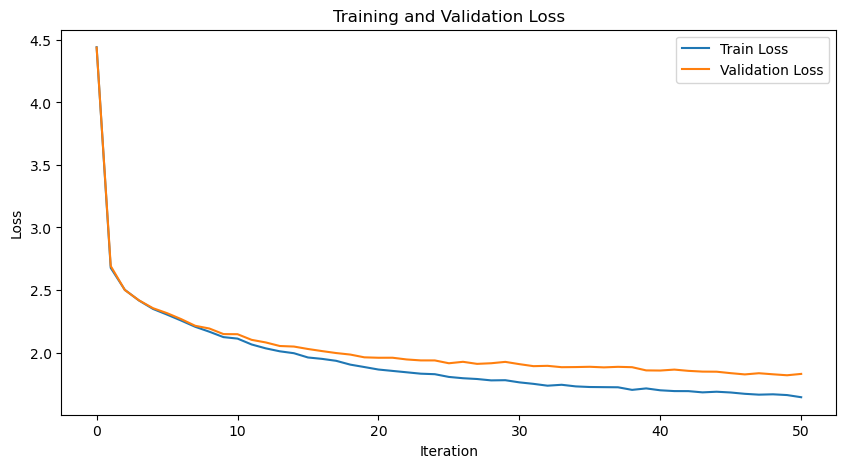

In [14]:
# 绘制损失曲线图
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# 保存图片并显示
plt.savefig('loss_plot.png')
plt.show()

In [ ]:
# 生成新的文本
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))